In [2]:
@show Threads.nthreads()
@assert Threads.nthreads() > 1

Threads.nthreads() = 6


In [9]:
gethostname()

"r35c4t4n4"

# Exercise: Parallel Monte Carlo (Threads)

Calculate the value of $\pi$ through parallel direct Monte Carlo.

A unit circle is inscribed inside a unit square with side length 2 (from -1 to 1). The area of the circle is $\pi$, the area of the square is 4, and the ratio is $\pi/4$. This means that, if you throw $N$ darts randomly at the square, approximately $M=N\pi/4$ of those darts will land inside the unit circle.

Throw darts randomly at a unit square and count how many of them ($M$) landed inside of a unit circle. Approximate $\pi \approx 4M/N$. Visualization:

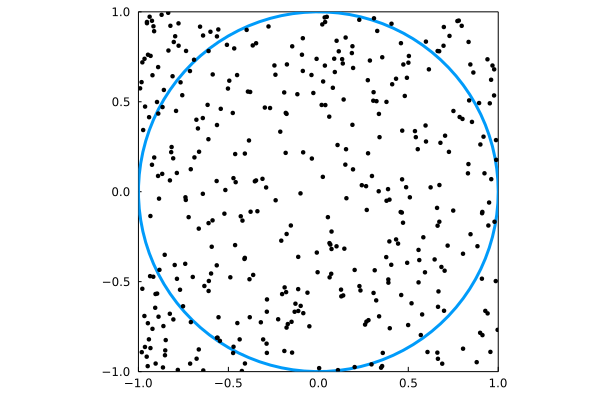

In [3]:
ENV["GKS_ENCODING"] = "utf-8"
using Plots, Distributions

# plot circle
circlepts = Plots.partialcircle(0, 2π, 100)
plot(circlepts, aspect_ratio=:equal, xlims=(-1, 1), ylims=(-1, 1), legend=false, lw=3, grid=false, frame=:box)

# plot darts
N = 400
d = Uniform(-1, 1)
scatter!(rand(d, N), rand(d, N), ms=2.5, color=:black)

### Basic Julia Implementation

In [4]:
function compute_pi(N)
    M = 0 # number of darts that landed in the circle
    for i in 1:N
        if sqrt(rand()^2 + rand()^2) < 1.0
            M += 1
        end
    end
    return 4 * M / N
end

compute_pi (generic function with 1 method)

In [5]:
compute_pi(10_000_000)

3.141332

### Tasks

1. Based on `compute_pi`, write a function `compute_pi_parallel(N::Int)` which does the same but divides the work among the available `Threads.nthreads()` threads.

2. Benchmark and compare the serial and parallel variants.

3. Write a function `compute_pi_multiple(Ns::Vector{Int})` which computes $\pi$ for all given $N$ values. The function should be serial and based on `compute_pi`.

4. Write a function `compute_pi_multiple_parallel(Ns::Vector{Int})` which does the same as in 3) but in parallel by using multithreading. The function should also be based on `compute_pi`.

5. Benchmark and compare the methods from 3) and 4).

6. Calculate $\pi$ estimates for `Ns = ceil.(Int, exp10.(range(1, stop=8, length=50)))`. Plot $\pi$ vs $N$ on a semi-log plot (i.e. provide `xscale=:log10` as a keyword argument to `plot`).

7. Bonus: Try to write a function `compute_pi_multiple_double_parallel(Ns::Vector{Int})` which computes $\pi$ for all given $N$ values. The calculation should be "as parallel as possible". Multiple different values of $N$ should be calculated at the same time and every one of those calculations should be parallel as well.

A reasonable value could be `N = 10_000_000`.

In [6]:
using BenchmarkTools
using LinearAlgebra
using ThreadsX
using FLoops

In [7]:
# 1) + 2)
function compute_pi_parallel_threadsx(N::Int)
    nt = Threads.nthreads()
    pi_sum = ThreadsX.sum(compute_pi(ceil(Int, N / nt)) for i in 1:nt)
    return pi_sum / nt  # average value
end

function compute_pi_parallel_floops(N::Int)
    nt = Threads.nthreads()
    @floop for i in 1:nt
        local_pi = compute_pi(ceil(Int, N / nt))
        @reduce(pi_sum += local_pi)
    end
    return pi_sum / nt  # average value
end

@btime compute_pi_parallel_threadsx(10_000_000)
@btime compute_pi_parallel_floops(10_000_000)

  8.111 ms (48 allocations: 2.95 KiB)
  8.114 ms (50 allocations: 2.98 KiB)


3.1421605715678855

In [8]:
# 2)
@btime compute_pi(10_000_000)

  48.526 ms (0 allocations: 0 bytes)


3.1419012

In [10]:
# 3) + 5)
function compute_pi_multiple(Ns::Vector{Int})
    pis = zeros(length(Ns))

    for i = 1:length(Ns)
        pis[i] = compute_pi(Ns[i])
    end

    return pis
end

some_Ns = [1_000_000, 2_000_000, 3_000_000, 4_000_000]

@btime compute_pi_multiple(some_Ns)

  48.493 ms (1 allocation: 96 bytes)


4-element Vector{Float64}:
 3.1443
 3.14034
 3.1397253333333333
 3.140459

In [11]:
# 4) + 5)

function compute_pi_multiple_parallel_threadsx(Ns::Vector{Int})
    pis = ThreadsX.map(compute_pi, Ns)
    return pis
end

function compute_pi_multiple_parallel_floops(Ns::Vector{Int})
    pis = Vector{Float64}(undef, length(Ns))
    @floop for i in eachindex(Ns)
        pis[i] = compute_pi(Ns[i])
    end
    return pis
end

some_Ns = [1_000_000, 2_000_000, 3_000_000, 4_000_000]

@btime compute_pi_multiple_parallel_threadsx($some_Ns)
@btime compute_pi_multiple_parallel_floops($some_Ns)

  19.386 ms (33 allocations: 2.19 KiB)
  19.407 ms (25 allocations: 1.83 KiB)


4-element Vector{Float64}:
 3.141476
 3.142056
 3.142554666666667
 3.141459

In [12]:
# 7)

function compute_pi_multiple_nested_parallel_threadsx(Ns::Vector{Int})
    pis = ThreadsX.map(compute_pi_parallel_threadsx, Ns)
    return pis
end

function compute_pi_multiple_nested_parallel_floops(Ns::Vector{Int})
    pis = Vector{Float64}(undef, length(Ns))
    @floop for i in eachindex(Ns)
        pis[i] = compute_pi_parallel_floops(Ns[i])
    end
    return pis
end

some_Ns = [1_000_000, 2_000_000, 3_000_000, 4_000_000]

@btime compute_pi_multiple_nested_parallel_threadsx($some_Ns)
@btime compute_pi_multiple_nested_parallel_floops($some_Ns)

  8.171 ms (260 allocations: 15.25 KiB)
  8.161 ms (236 allocations: 14.11 KiB)


4-element Vector{Float64}:
 3.1420057159885686
 3.141211717576565
 3.140609333333334
 3.1413334293332853

  0.301256 seconds (5.03 k allocations: 287.501 KiB, 5.57% compilation time)


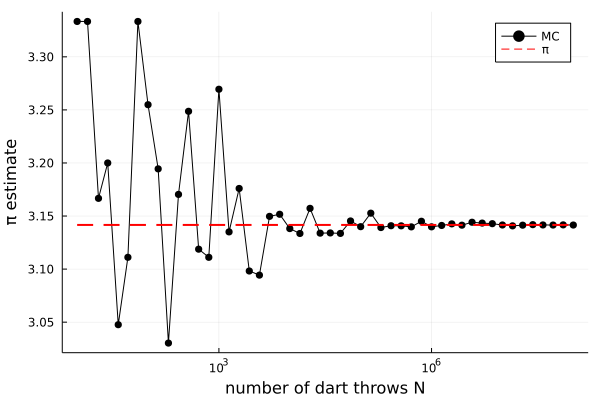

In [13]:
# 6)
Ns = ceil.(Int, exp10.(range(1, stop=8, length=50)))
@time pis = compute_pi_multiple_nested_parallel_threadsx(Ns)

plot(Ns, pis, color=:black, marker=:circle, lw=1, label="MC", xscale=:log10)
plot!(x -> π, label="π", xscale=:log10, linestyle=:dash, color=:red, lw=2)
ylabel!("π estimate")
xlabel!("number of dart throws N")